In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.image as mpim
import matplotlib.animation as animation

/tmp/ipykernel_45196/1616106777.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#open files
file = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NumuSelection_Modern_Uboone_Lite.root")
file2 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Numu_Lite.root")
file3 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Nu_Osc_Lite.root") 
file4 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Intrinsic_Nue_Lite.root")

In [4]:
#grab the "protons on target" measurement for each dataset
pot = file["totpot"].member("fElements")[0] 
pot2 = file2["totpot"].member("fElements")[0]
pot3 = file3["totpot"].member("fElements")[0]
pot4 = file4["totpot"].member("fElements")[0]

#unpack each file and grab the relevant variables
Numu_cc = file["tree_numu_cc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Numu_nc = file["tree_numu_nc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Numu = file2["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_NuOsc = file3["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Intrinsic = file4["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")

# doing our "final" weight calculation:
# weights = desired POT * simulated_weights / simulated_POT
des_pot = 1.2e+21
# using 1.2e21 as our desired POT as the ~total beam collected over microboone's lifetime
Numu_cc["pot_weight"] = Numu_cc["weight"] * (des_pot / pot)
Numu_nc["pot_weight"] = Numu_nc["weight"] * (des_pot / pot)
Nue_Numu["pot_weight"] = Nue_Numu["weight"] * (des_pot / pot2)
Nue_NuOsc["pot_weight"] = Nue_NuOsc["weight"] * (des_pot / pot3)
Nue_Intrinsic["pot_weight"] = Nue_Intrinsic["weight"] * (des_pot / pot4)


In [5]:
#split datasets into neutrino types
cc_mu = Numu_cc[(Numu_cc["nu_pdg"] == 14.0)]
cc_mua = Numu_cc[(Numu_cc["nu_pdg"] == -14.0)]
nc_mu = Numu_nc[(Numu_nc["nu_pdg"] == 14.0)]
nc_mua = Numu_nc[(Numu_nc["nu_pdg"] == -14.0)]
osc_e = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == 12.0)]
osc_ea = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == -12.0)]
intrin_e = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == 12.0)]
intrin_ea = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == -12.0)]

In [6]:
# FROM: https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1116-PUB.pdf
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
# sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2

# FROM: https://arxiv.org/pdf/1609.07803
# sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
# sin2(2*theta_ee) ~= sin2(2*theta_14)
# sin2(2*theta_mumu) ~= sin2(2*theta_24)

#best fit parameters from IceCube:
# deltm2_41 = 4.5 eV2
# sin2(2*theta_24) = 0.1

#best fit parameters from PROSPECT:
# deltm2_41 = 0.5 eV2
# sin2(2*theta_14) = 0.35

In [7]:
# probability for mu->e, e->e, and mu->mu oscillations
# in terms of Ue4, Um4, and deltam2_41
def prob_energy(params, deltam_41, L_E, Paa="mue", sin2s=False):
    if (sin2s==False):
        Ue4, Um4 = params
    
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            probab = ((4*(Ue4**2)*(Um4)**2) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            probab =  1 - ((4*(Ue4**2)*(1-(Ue4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            probab = 1 - ((4*(Um4**2)*(1-(Um4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    else:
        sin2_14, sin2_24 = params
        
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            # sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
            probab = (0.25 * sin2_14 * sin2_24) * (np.sin(1.27*deltam_41*L_E))**2
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            # sin2(2*theta_ee) ~= sin2(2*theta_14)
            probab =  1 - ((sin2_14) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            # sin2(2*theta_mumu) ~= sin2(2*theta_24)
            probab = 1 - ((sin2_24) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    return(probab)


In [8]:
deltam2s = np.logspace(np.log10(0.1),np.log10(10),30, base=10)

#if I want sin2_mue = [1e-5, 0.1] and sin2_ee = [0,0.5]
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2

Ue4s = np.logspace(np.log10(0.01), np.log10(0.4), 30, base=10)
Um4s = np.logspace(np.log10(0.01), np.log10(0.4), 30, base=10)

In [9]:
# find total number of appearance and disappearance nue
osc_e.shape[0] #total number of possible appearance nue from num
intrin_e.shape[0] #total number of intrinsic nue

#set deltam2 to specific value, to look at just 2 variables
deltam2 = 1

# ((4*(Ue4**2)*(Um4)**2) * (np.sin(1.27*deltam_41*L_E))**2)
# 1 - ((4*(Ue4**2)*(1-(Ue4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)

#instead of looking at each individual nue (and it's specific L and E ) look "on average" with overall L and E for general area
#L = 0.47 #km 
#E = 0.5 #GeV

osc_L = np.mean(osc_e["true_baseline"])/1000
osc_E = np.mean(osc_e["true_energy"])

intrin_L = np.mean(intrin_e["true_baseline"])/1000
intrin_E = np.mean(intrin_e["true_energy"])

#however, we don't want just the "straight" numbers, we want the numbers after weighting them, as we would see on the histogram

# find the average oscillation pot_weight for appearance and disappearance nue as a whole
# there seem to be 2 pot_weights in the data: 0.805 and 0.048
from scipy import stats
stats.mode(osc_e["pot_weight"])
osc_e[(osc_e["pot_weight"]<0.8)]

# why are there 2 weights? Should is split up the data according to weight or take mean?
# their overall mean is below:
avg_osc_pot_weight = np.mean(osc_e["pot_weight"].values)

# find the average intrinsic pot_weight
# this also has 2 types (original weights 0.8 and 0.48 like before, but different pot_weight)
# the average is:
avg_intrin_pot_weight = np.mean(intrin_e["pot_weight"].values)

In [10]:
# now set up function that returns the numbers and differences based on Ue4 and Um4
def average_diff(Ue4, Um4):
    ap_prob = ((4*(Ue4**2)*(Um4)**2) * (np.sin(1.27*deltam2*osc_L/osc_E))**2)
    ap_num = ap_prob * avg_osc_pot_weight * osc_e.shape[0]
    
    dis_prob = 1 - ((4*(Ue4**2)*(1-(Ue4)**2)) * (np.sin(1.27*deltam2*intrin_L/intrin_E))**2)
    dis_num = dis_prob * avg_intrin_pot_weight * intrin_e.shape[0]
    
    diff = ap_num - dis_num
    return(ap_num, dis_num, diff)

#function that returns required Um4 for each Ue4, assuming the number diff = 0
def zero_diff(Ue4):
    dis_prob = 1 - ((4*(Ue4**2)*(1-(Ue4)**2)) * (np.sin(1.27*deltam2*intrin_L/intrin_E))**2)
    divided_ap_prob = (4*(Ue4**2) * (np.sin(1.27*deltam2*osc_L/osc_E))**2)
    constants = (avg_intrin_pot_weight * intrin_e.shape[0]) / (avg_osc_pot_weight * osc_e.shape[0])
    
    Um4 = np.sqrt(constants * dis_prob / divided_ap_prob)
    return Um4

Text(0.5, 1.0, 'Ue4 and Um4 Combinations with Nue Appearance/Disappearance Cancellation')

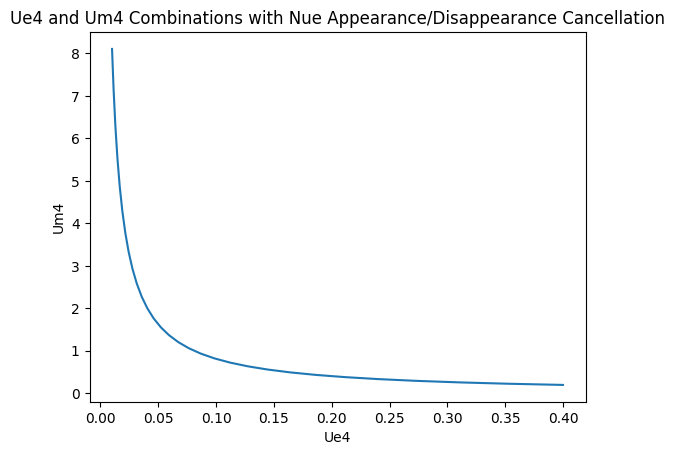

In [14]:
plt.plot(Ue4s, zero_diff(Ue4s))
plt.xlabel("Ue4")
plt.ylabel("Um4")
plt.title("Ue4 and Um4 Combinations with Nue Appearance/Disappearance Cancellation")
#plt.ylim(0,0.4)

In [12]:
diffs = np.zeros([Ue4s.shape[0],Um4s.shape[0]])

for i in range(Ue4s.shape[0]):
    for j in range(Um4s.shape[0]):
        ap_num, dis_num, diff = average_diff(Ue4s[i], Um4s[j])
        diffs[i][j] = diff

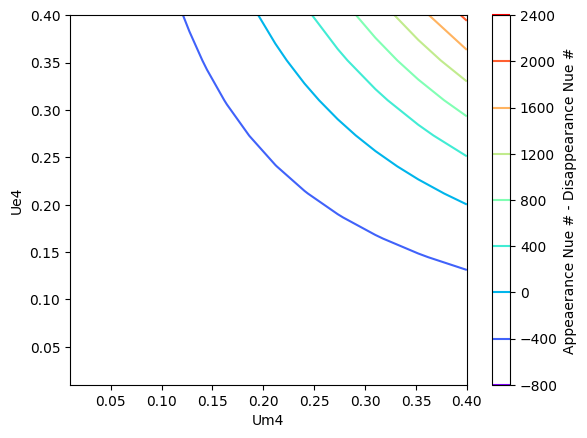

In [15]:
plt.contour(Um4s, Ue4s, diffs, cmap="rainbow")
plt.xlabel("Um4")
plt.ylabel("Ue4")
plt.colorbar(label="Appeaerance Nue # - Disappearance Nue #")